**TODO Flowchart**
1. Build dataset out of the data availale (train and validation)
2. Normalize the data
3. Build model
     1. Create augmentation layer for regularization
     2. Define CNN layers
     3. Dropout
     4. DNN layers (classification layer)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

**Preparing data pipeline**

In [3]:
base_dir = os.path.join('/kaggle/input/american-sign-language-asl/American Sign Language (ASL)', 'dataAT')

In [4]:
valid_data = image_dataset_from_directory(base_dir, validation_split=0.3, subset='validation', seed=45, image_size=(224,224), batch_size=100)
train_data = image_dataset_from_directory(base_dir, validation_split=0.3, subset='training', seed=45, image_size=(224,224), batch_size=100)

Found 8100 files belonging to 27 classes.
Using 2430 files for validation.


2023-01-07 12:50:53.177664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:50:53.261477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:50:53.262200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 12:50:53.273510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 8100 files belonging to 27 classes.
Using 5670 files for training.


In [5]:
normalizer = tf.keras.layers.Rescaling(1./255)

In [6]:
#Normalize the data
valid_data_nz = valid_data.map(lambda img, lbl: (normalizer(img), lbl))
train_data_nz = train_data.map(lambda img, lbl: (normalizer(img),lbl))

In [7]:
#GPU Performance
valid_data_nz = valid_data_nz.cache().prefetch(tf.data.AUTOTUNE)
train_data_nz = train_data_nz.cache().prefetch(tf.data.AUTOTUNE)

**Model**

In [8]:
# RandomFlip, RandomZoom, RandomRotation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(input_shape=(224,224,3)),
    tf.keras.layers.RandomRotation(0.125),
    tf.keras.layers.RandomZoom((0.3, 0.3))
])

In [9]:
vgg16_layer = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 3s 0us/step


In [10]:
vgg16_layer.trainable = False

In [11]:
model = tf.keras.Sequential([
    vgg16_layer,
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(27)
])

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                3483      
Total params: 17,929,563
Trainable params: 3,214,875
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
#Operation to save the best model in early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model", save_best_only=True)

In [15]:
EPOCHS = 500
history = model.fit(train_data_nz, epochs=EPOCHS, validation_data=valid_data_nz, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


2023-01-07 12:50:59.893104: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-07 12:51:03.902346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - 46s 510ms/step - loss: 2.4373 - accuracy: 0.2557 - val_loss: 1.1945 - val_accuracy: 0.8280


2023-01-07 12:51:46.325346: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/500
57/57 [==============================] - 15s 268ms/step - loss: 1.6129 - accuracy: 0.4711 - val_loss: 0.6563 - val_accuracy: 0.9749
Epoch 3/500
57/57 [==============================] - 15s 268ms/step - loss: 1.3660 - accuracy: 0.5369 - val_loss: 0.3861 - val_accuracy: 0.9955
Epoch 4/500
57/57 [==============================] - 15s 268ms/step - loss: 1.2620 - accuracy: 0.5517 - val_loss: 0.2763 - val_accuracy: 0.9963
Epoch 5/500
57/57 [==============================] - 15s 268ms/step - loss: 1.1913 - accuracy: 0.5691 - val_loss: 0.2255 - val_accuracy: 0.9984
Epoch 6/500
57/57 [==============================] - 15s 268ms/step - loss: 1.0880 - accuracy: 0.6048 - val_loss: 0.1609 - val_accuracy: 0.9992
Epoch 7/500
57/57 [==============================] - 15s 268ms/step - loss: 1.0585 - accuracy: 0.5986 - val_loss: 0.1300 - val_accuracy: 0.9992
Epoch 8/500
57/57 [==============================] - 15s 268ms/step - loss: 1.0286 - accuracy: 0.6129 - val_loss: 0.1106 - val_accuracy:

In [16]:
model = tf.keras.models.load_model("best_model")

In [17]:
model.evaluate(valid_data_nz)

25/25 [==============================] - 5s 182ms/step - loss: 0.0145 - accuracy: 0.9996


[0.014533144421875477, 0.9995884895324707]

In [18]:
def plot_image(image, label):
    ax = plt.subplot(1, 1, 1)
    plt.imshow(image.numpy())
    plt.title(train_data.class_names[label])


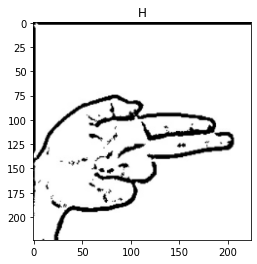

In [19]:
images, labels = next(iter(valid_data_nz))
index = np.random.randint(0, 99)
image = images[index]
label = labels[index]

plot_image(image, label)

In [20]:
pred = model.predict(tf.expand_dims(image, 0), label)
letter = train_data.class_names[tf.argmax(pred[0])]
print("The letter is: ", letter)

The letter is:  H
